Dataset shape: (12020, 2)


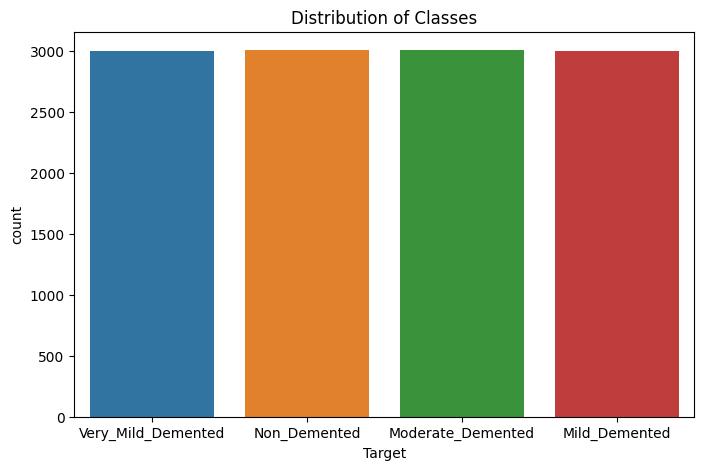

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


In [2]:
 import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152, InceptionV3,InceptionResNetV2,DenseNet121,DenseNet169,DenseNet201,Xception,NASNetMobile, NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

DATA_PATH = "/kaggle/input/preprocess-dataset-augmentation/AD_AUG"
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()
    dataframe = load_data(DATA_PATH)
explore_data(dataframe)
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)
 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 4, 4, 2048)     │     23,587,712 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 4, 4, 512)      │     14,714,688 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 32768)          │              0 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 8192)           │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 40960)          │              0 │ flatten_4[0][0],       │
│ (Concatenate)             │                        │                │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1024)           │     41,944,064 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1024)           │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │        524,800 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 4)              │          2,052 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 80,773,316 (308.13 MB)

 Trainable params: 42,470,916 (162.01 MB)

 Non-trainable params: 38,302,400 (146.11 MB)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.4196 - loss: 28.6798 - val_accuracy: 0.8644 - val_loss: 18.4558 - learning_rate: 1.0000e-05
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.6992 - loss: 18.1276 - val_accuracy: 0.9056 - val_loss: 15.4229 - learning_rate: 1.0000e-05
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.7854 - loss: 15.3379 - val_accuracy: 0.9280 - val_loss: 13.8498 - learning_rate: 1.0000e-05
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8400 - loss: 13.7874 - val_accuracy: 0.9463 - val_loss: 12.6620 - learning_rate: 1.0000e-05
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8741 - loss: 12.5899 - val_accuracy: 0.9588 - val_loss: 11.6284 - learning_rate: 1.0000e-05
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8930 - loss: 11.5555 - val_accuracy: 0.9634 - val_loss: 10.6969 - learning_rate: 1.0000e-05
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 

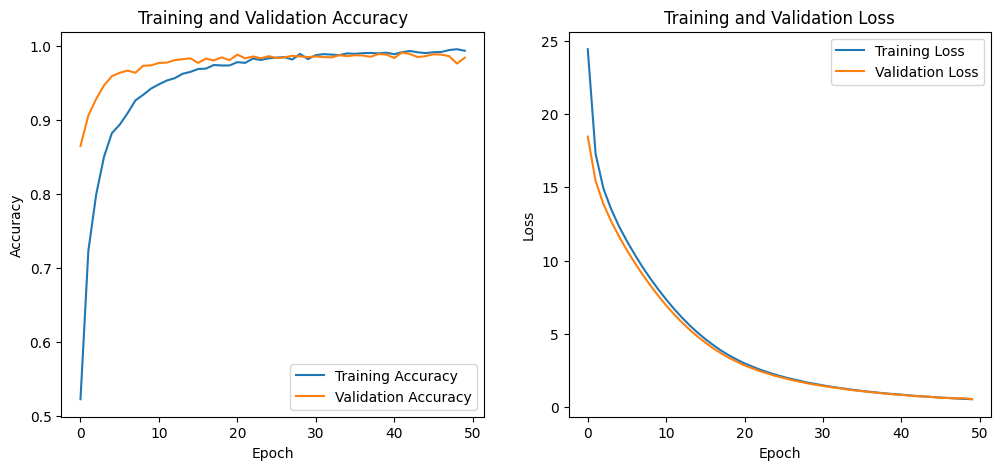

151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.98      0.98      0.98       623
 Moderate_Demented       1.00      1.00      1.00       601
      Non_Demented       0.98      1.00      0.99       591
Very_Mild_Demented       0.98      0.96      0.97       589

          accuracy                           0.98      2404
         macro avg       0.98      0.98      0.98      2404
      weighted avg       0.98      0.98      0.98      2404



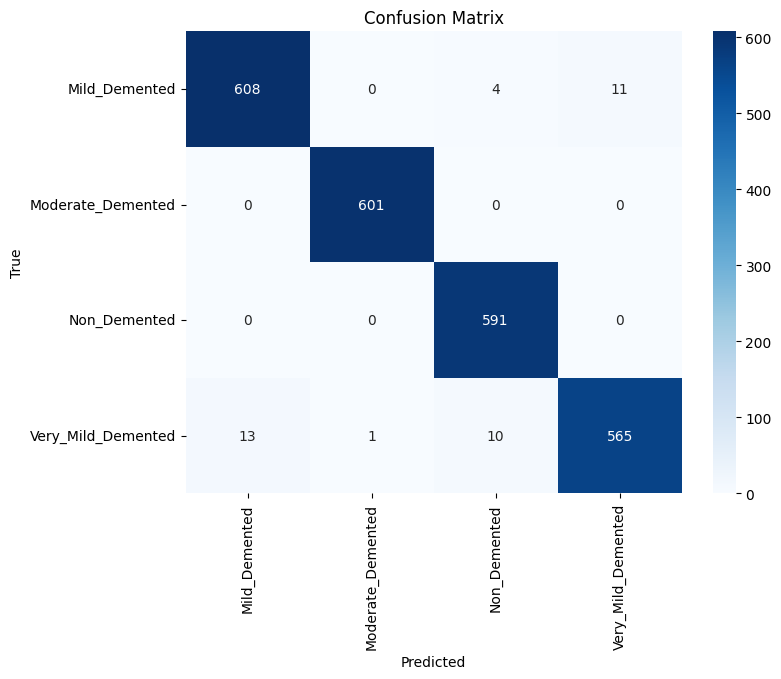

In [8]:
from keras.layers import Input, Concatenate, Flatten
from keras.models import Model
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Load ResNet50 and VGG16 models without the top layers
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of ResNet50 and VGG16
for layer in resnet50.layers:
    layer.trainable = False

for layer in vgg16.layers:
    layer.trainable = False

# Create the hybrid model
input_layer = Input(shape=(128, 128, 3))

# Get the output of ResNet50 and VGG16
resnet50_output = resnet50(input_layer)
vgg16_output = vgg16(input_layer)

# Flatten the outputs
resnet50_output = Flatten()(resnet50_output)
vgg16_output = Flatten()(vgg16_output)

# Concatenate the outputs
merged = Concatenate()([resnet50_output, vgg16_output])

# Add additional layers with regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(merged)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(train_data.class_indices), activation='softmax')(x)

# Create the final model
hybrid_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
hybrid_model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
hybrid_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)

# Train the model
history = hybrid_model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,  # Increase epochs
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = hybrid_model.evaluate(test_data)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Generate predictions
y_pred = hybrid_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = test_data.classes

# Generate classification report
class_names = list(train_data.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step


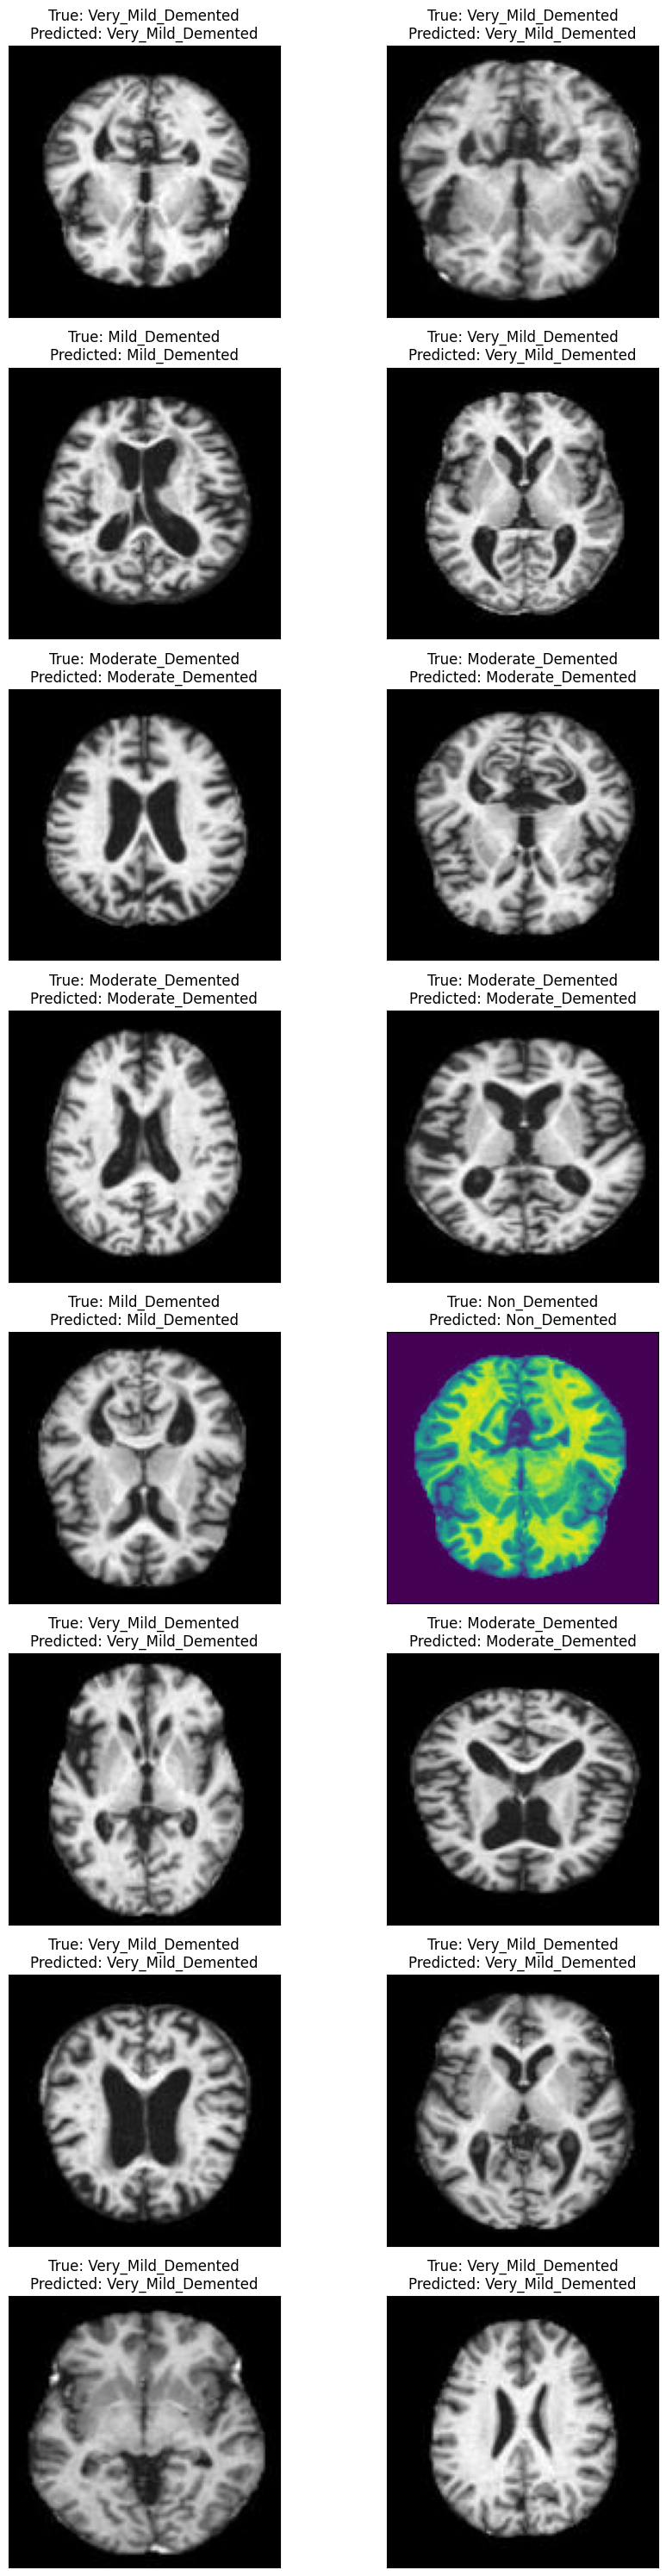

In [23]:

# Generate predictions
y_pred = hybrid_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = test_data.classes



# Display Random Images with Predictions
filepaths = test_data.filepaths
class_indices = test_data.class_indices
class_labels = {v: k for k, v in class_indices.items()}

true_label_names = [class_labels[label] for label in y_true]
pred_label_names = [class_labels[label] for label in y_pred]

# Randomly select images to display
random_indices = random.sample(range(len(filepaths)), min(16, len(filepaths)))

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 30), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    img = plt.imread(filepaths[idx])  # Read the image
    true_label = true_label_names[idx]
    pred_label = pred_label_names[idx]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPredicted: {pred_label}")

plt.tight_layout()
plt.show()